In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# Importing the required libraries
from keras.models import Sequential
from scipy.misc import imread
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

from sklearn.metrics import log_loss
from keras.models import Model
from keras.utils import multi_gpu_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.preprocessing.image import ImageDataGenerator

/home/arpit/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
num_classes = 30

In [4]:
model = VGG16(weights='imagenet', include_top=True)

In [5]:
model.layers.pop()
x = model.layers[-1].output
x = Dense(num_classes, activation='softmax')(x)
model = Model(input = model.input, output = x)

/home/arpit/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
for layer in model.layers[:11]:
    layer.trainable = False

In [8]:

# Check the trainable status of the individual layers# Check  # Check  
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f0562de6198> False
<keras.layers.convolutional.Conv2D object at 0x7f0562de65c0> False
<keras.layers.convolutional.Conv2D object at 0x7f0562de63c8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0562de6dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f054c54bda0> False
<keras.layers.convolutional.Conv2D object at 0x7f054c567240> False
<keras.layers.pooling.MaxPooling2D object at 0x7f054c4faf28> False
<keras.layers.convolutional.Conv2D object at 0x7f054c51f668> False
<keras.layers.convolutional.Conv2D object at 0x7f054c51f6d8> False
<keras.layers.convolutional.Conv2D object at 0x7f054c4ce550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f054c4e2cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f054c484710> True
<keras.layers.convolutional.Conv2D object at 0x7f054c484780> True
<keras.layers.convolutional.Conv2D object at 0x7f054c4355c0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f054c447d68> True


In [9]:

# Learning rate is changed to 0.001# Learni 
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

nb_train_samples = 13000
# nb_validation_samples = 5000
epochs = 20
batch_size = 64

In [12]:
batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=True,
        seed = 42)  # since we use binary_crossentropy loss, we need binary labels

Found 13000 images belonging to 30 classes.


In [13]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=13000 // batch_size,
        epochs=100)

Epoch 1/100
203/203 [==============================] - 292s 1s/step - loss: 1.7168 - acc: 0.5106
Epoch 2/100
203/203 [==============================] - 263s 1s/step - loss: 0.7595 - acc: 0.7655
Epoch 3/100
203/203 [==============================] - 244s 1s/step - loss: 0.5543 - acc: 0.8278
Epoch 4/100
203/203 [==============================] - 244s 1s/step - loss: 0.4154 - acc: 0.8684
Epoch 5/100
203/203 [==============================] - 244s 1s/step - loss: 0.3332 - acc: 0.8934
Epoch 6/100
203/203 [==============================] - 244s 1s/step - loss: 0.2652 - acc: 0.9162
Epoch 7/100
203/203 [==============================] - 244s 1s/step - loss: 0.2149 - acc: 0.9315
Epoch 8/100
203/203 [==============================] - 244s 1s/step - loss: 0.1572 - acc: 0.9495
Epoch 9/100
203/203 [==============================] - 244s 1s/step - loss: 0.1249 - acc: 0.9596
Epoch 10/100
203/203 [==============================] - 243s 1s/step - loss: 0.1242 - acc: 0.9621
Epoch 11/100
203/203 [=======

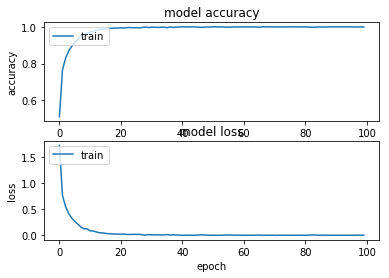

In [14]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
# plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
# plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [15]:
# model.save_weights('vgg16_fine_tune_100_epochs.h5')

### Making the prediction for test dataset

In [16]:
test_generator = test_datagen.flow_from_directory(
    directory="data/test",
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 6000 images belonging to 1 classes.


In [17]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)

6000/6000 [==============================] - 93s 15ms/step


In [18]:
pred[0]

array([9.4490052e-17, 8.1873907e-17, 5.0985748e-12, 1.8803351e-16,
       9.9999988e-01, 1.3142322e-18, 2.2674232e-10, 1.8866966e-13,
       5.8655920e-16, 2.0080314e-15, 1.2431751e-07, 7.8285663e-11,
       3.5175132e-13, 2.3191699e-15, 5.9220417e-14, 8.3373766e-11,
       6.0689100e-18, 2.4610117e-17, 1.8625329e-10, 1.2416166e-17,
       1.2857291e-14, 4.6918197e-18, 1.6320506e-08, 7.2178807e-17,
       6.5447037e-19, 4.8861916e-17, 5.3937962e-22, 3.2100570e-14,
       4.0232540e-20, 2.0181133e-16], dtype=float32)

In [19]:
train_generator.class_indices

{'antelope': 0,
 'bat': 1,
 'beaver': 2,
 'bobcat': 3,
 'buffalo': 4,
 'chihuahua': 5,
 'chimpanzee': 6,
 'collie': 7,
 'dalmatian': 8,
 'german+shepherd': 9,
 'grizzly+bear': 10,
 'hippopotamus': 11,
 'horse': 12,
 'killer+whale': 13,
 'mole': 14,
 'moose': 15,
 'mouse': 16,
 'otter': 17,
 'ox': 18,
 'persian+cat': 19,
 'raccoon': 20,
 'rat': 21,
 'rhinoceros': 22,
 'seal': 23,
 'siamese+cat': 24,
 'spider+monkey': 25,
 'squirrel': 26,
 'walrus': 27,
 'weasel': 28,
 'wolf': 29}

In [20]:
filenames=test_generator.filenames

In [21]:
results=pd.DataFrame({"filename":filenames})
results.to_csv("results/filenames.csv",index=False)

In [22]:
results=pd.DataFrame(pred)
results.to_csv("results/results_vgg16_fine_tune.csv",index=False)